# Real Time Lip Reader!

In [169]:
import os
import cv2 
import tensorflow as tf 
import numpy as np 
from typing import List
from matplotlib import pyplot as plt 
import imageio

In [170]:
phys = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(phys[0], True)
except:
    pass

## Data loading functions to preprocess the videos and annotations

In [171]:
def load_video(path:str)->List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    #store all frames
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        #isolate mouth region 
        # (im not going to use a dlib mouth extractor sorry)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    #mean and std of the frames
    mean = tf.math.reduce_mean(tf.cast(frames, tf.float32))
    
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean)/std, tf.float32)


In [172]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [173]:
#now we can use a string lookup loss function
#this is a custom loss function that will take the string and convert to num

char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token='')
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token='', invert=True)

print(
    f"The vocab is: {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocab is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [174]:
print(char_to_num(['a', 'h', 'm', 'a', 'd']))
print(num_to_char([1, 8, 13, 1, 4]))

tf.Tensor([ 1  8 13  1  4], shape=(5,), dtype=int64)
tf.Tensor([b'a' b'h' b'm' b'a' b'd'], shape=(5,), dtype=string)


In [175]:
def load_alignments(path:str)->List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    #read all the alignments and split them up
    tokens = []
    for line in lines:
        line = line.split()
        #if it contains silence we do not need if ofc
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [176]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 'data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data','data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [177]:
path1 = '.data\\data\\s1\\bbaf2n.mpg'
#tf.convert_to_tensor(path1).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

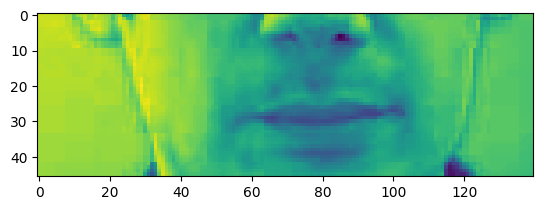

In [178]:
frames, alignments = load_data(tf.convert_to_tensor(path1))
plt.imshow(frames[0])

In [179]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [180]:
def mappable_fn(path):
    #for string processing for whatever reason it doesn't 
    #work without this. Maps the load data func as a py_function
    return tf.py_function(load_data, [path], (tf.float32, tf.int64))

## Data Pipeline

In [200]:
#get all files ending in .mpg and then shuffle + mappable func
data = tf.data.Dataset.list_files('data/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=True)
data = data.map(mappable_fn)
#batches of 2, pad with zeros if less than 40
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
#preloading as training is happenign
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [201]:
frames, alignments = data.as_numpy_iterator().next()
print(alignments)
print(f"Length of frames: {len(frames)}")

[[19  5 20 39 23  8  9 20  5 39 23  9 20  8 39  3 39  6  9 22  5 39 19 15
  15 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [12  1 25 39 23  8  9 20  5 39  9 14 39 12 39 15 14  5 39  1  7  1  9 14
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Length of frames: 2


In [202]:
weird = data.as_numpy_iterator()
val = weird.next(); val[0]

array([[[[[ 1.5314748 ],
          [ 1.3847177 ],
          [ 1.5314748 ],
          ...,
          [ 0.2840391 ],
          [ 0.3207284 ],
          [ 0.3207284 ]],

         [[ 1.5314748 ],
          [ 1.3480284 ],
          [ 1.6048534 ],
          ...,
          [ 0.2840391 ],
          [ 0.3207284 ],
          [ 0.3207284 ]],

         [[ 1.421407  ],
          [ 1.421407  ],
          [ 1.421407  ],
          ...,
          [ 0.43079624],
          [ 0.39410695],
          [ 0.39410695]],

         ...,

         [[ 1.0178249 ],
          [ 1.0178249 ],
          [ 1.0178249 ],
          ...,
          [ 0.17397124],
          [ 0.13728195],
          [ 0.10059267]],

         [[ 0.98113555],
          [ 0.98113555],
          [ 0.98113555],
          ...,
          [ 0.13728195],
          [ 0.13728195],
          [ 0.10059267]],

         [[ 0.98113555],
          [ 0.98113555],
          [ 0.98113555],
          ...,
          [ 0.13728195],
          [ 0.10059267],
          

In [203]:
import numpy as np

array = val[0][0]

# Convert the array to uint8 if it's not already
if array.dtype != np.uint8:
    array = (array * 255).astype(np.uint8)

if array.shape[-1] == 1: 
    array = np.squeeze(array, axis=-1)  # Remove the last dimension

# Save the gif
imageio.mimsave('test.gif', array)

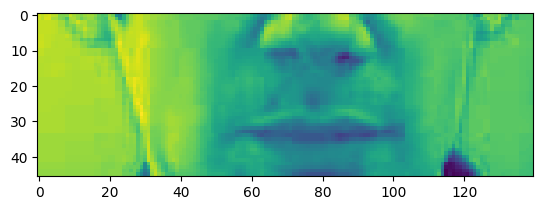

In [204]:
# 0: videos, 0: 1st batch vid, 0: 1st frame
plt.imshow(val[0][0][0])

In [205]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red in n five soon'>

## DNN!

In [206]:
# using CTC loss function 
# since many frames have same data

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [207]:
input_shape = data.as_numpy_iterator().next()[0][0].shape
input_shape[:3]

(75, 46, 140)

In [208]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))
#its going to be 75, 41 output since 75 frames and 41 chars
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [209]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_12 (Activation)  (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 75, 23, 70, 128)   0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_13 (Activation)  (None, 75, 23, 70, 256)   0         
                                                      

In [210]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [211]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxppyy'>

In [212]:
print(f"Model Input Shape: {model.input_shape}")
print(f"Model Output Shape: {model.output_shape}")

Model Input Shape: (None, 75, 46, 140, 1)
Model Output Shape: (None, 75, 41)


## Setup Training Options and Train

In [213]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [214]:
#from the ASR paper 
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [215]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [216]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [166]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100

  1/500 [..............................] - ETA: 2:36:51 - loss: 228.8118

KeyboardInterrupt: 